## Basic concepts

By now, CRPropa is installed together with the Juypter interface and we are ready to begin.

### Candidates and modules

To use CRPropa commands, tools and classes within Pyhton, the first step is to import it into the main namespace:

In [2]:
from crpropa import *

or, alternatively, if one needs better control over different commands and modules `import crpropa as crp` which will require adding the `crp.` prefix before every command or class initiated from CRPropa.

The principal object of interest, a cosmic ray, within the framework is called a **candidate**. The candidate is a particle described by an associated physical state. The particle state can be defined with many different properties, but two of the most fundamental ones are the particle's **position** and the particle's movement **direction**. The actual state of a candidate is referred as "current" one.
Here is an example where Vector3d is a CRPropa object representing a 3D vector:

In [3]:
c = Candidate()
c.current.setPosition(Vector3d(10, 0, 0))
c.current.setDirection(Vector3d(-1, 0, 0))

The candidate itself is a passive object and only external mechanisms, called **modules**, can change its state.
The first example of such a module in the context of the framework application is the rectilinear propagational module - ``SimplePropagation``. Its purpose, as the name suggests, is to propagate the candidate in the simplest way, i.e., to change the candidate's position following a straight line in the defined direction.

In [7]:
module = SimplePropagation()

To describe how modules act on candidates, one should recall those numerical simulations necessarily discretise the continuity of the real world with computational **steps**. The candidate state is changed by modules in steps. In every step, the module process candidate with the **process method**.

Before continuing with processing, it is worth mentioning that modules can or even must take arguments during the initialization stage to set-up or change their default behaviour and it depends on the specific module which settings can be defined or modified. The modules' settings are described in [CRPropa documentation](http://crpropa.github.io/CRPropa3/annotated.html).

In the already introduced module, ``SimplePropagation``, one could change the minimum and the maximum distance for which the candidate can jump within one step. These changes can also be done later, after the initialization, with so-called **setters** (set methods) or just checked with **getters** (get methods).

In [4]:
module = SimplePropagation(1, 3) # (minStep, maxStep)
module.setMaximumStep(2)
print(module.getMaximumStep())

2.0


The process method can be used in a conjunction with any kind of loop, e.g.

In [5]:
for i in range(5):
    module.process(c)
    print("In step {}. position is {}".format(i+1, c.current.getPosition()))

In step 1. position is Vector(9, 0, 0)
In step 2. position is Vector(7, 0, 0)
In step 3. position is Vector(5, 0, 0)
In step 4. position is Vector(3, 0, 0)
In step 5. position is Vector(1, 0, 0)


After five iterations, the position is changed five times in the negative direction of the x-axis which is defined by ``setDirection()``. What needs an additional explanation is the propagated distance in these steps. To avoid the clash between different active modules in determining the step size, modules modify the candidate's current step with the minimum prescribed step while setting the maximum one for the next round. In that way, the next step would be bounded by the module which required the smallest maximum step. In case of the current example, the first step was 1 (minStep argument in ``SimplePropagation``), while all the later steps are 2 (given by ``setMaximumStep`` above).

At this point, before introducing a new physical content, a slight digression in a form physical units is needed. All physical quantities and parameters used in the code are in expressed the SI units. For example, those numbers, 1, 2 and 3, in the above example are 1, 2 and 3 meter(s). From now on, the explicit units will be used to avoid possible confusion, and it is advisable to do the same in every CRPropa code. If some units are not defined within the framework, one could use external python library such as [pint](http://pint.readthedocs.io) to carry out the conversions.

In [10]:
print("1 Mpc is {} meters in the international \
system of units, while 1 GeV is {} joules".format(1*Mpc, 1*GeV))

1 Mpc is 3.085677581491367e+22 meters in the international system of units, while 1 GeV is 1.602176487e-10 joules


Note the next example how to use pint:

In [6]:
from pint import UnitRegistry
ureg = UnitRegistry()

def convertunits(unitstring, convertto):
        unitfrom = ureg.parse_expression(unitstring)
        unitto = unitfrom.to(ureg.parse_expression(convertto))
        return unitto.magnitude

fromunits = "eV^-1 m^-2 s^-1 sr^-1"
tounits = "GeV^-1 km^-2 year^-1 sr^-1"
print("Flux: 1 {1} = {0} {2}".format(
    1*convertunits(fromunits, tounits), fromunits, tounits))

Flux: 1 eV^-1 m^-2 s^-1 sr^-1 = 3.1556925974699995e+22 GeV^-1 km^-2 year^-1 sr^-1


The candidate can virtually be any classified particle or nucleus with the assumption that its energy is dominating its mass, i.e., $pc=\sqrt{E^2-(mc^2)^2}\approx E$, so that it travels at the speed of light in the observer reference frame. The reason behind it is that the framework by design does not explicitly take into account time. The time parameter is merely recovered from the propagated length. Thus, a propagation module is always required since any other physical module stays inactive when time does not pass.

The particles are distinguished by the particle ID (PID) which inherits a numbering scheme defined by the Particle Data Group. CRPropa uses the [HepPID](http://lcgapp.cern.ch/project/simu/HepPDT/HepPDT.2.06.01/HepPID.pdf) implementation of the scheme. For the nuclei identification, CRPropa has its own implementation which is also specified by [PDG](http://pdg.lbl.gov/2008/reviews/rpp2008-rev-monte-carlo-numbering.pdf).

After demonstrating ``SimplePropagation`` module, ``NuclearDecay`` is yet another module which is relatively self-contained, hence, can be presented without too much overhead. ``NuclearDecay`` is a module which represents the decay of a nucleus. It will act only on unstable nuclei, of course. Let's examine the following lines which employ the mentioned concepts:

In [81]:
def decay_distance(pid, E):
    c = Candidate(pid, E)
    c.current.setPosition(Vector3d(0, 0, 0)*Mpc)
    c.current.setDirection(Vector3d(1, 0, 0))
    init_id = c.current.getId()

    module1 = SimplePropagation(0.01*pc, 10*pc)
    module2 = NuclearDecay()

    for step in range(200):
        module1.process(c)
        module2.process(c)
        if c.current.getId() != init_id:
            return c.current.getPosition().getR()
        
    return c.current.getPosition().getR()
            
# Li-8, half-life = 839.9 ms, E = 1 EeV
pid = nucleusId(8, 3)
E = 1*EeV

# make sample
dists = [decay_distance(pid, E)/pc for i in range(3000)]
mean_dist = sum(dists)/len(dists)
print("The mean length until the decay is {:.3g} pc".format(mean_dist))

The mean length until the decay is 1.64 pc


Depending on the particle energy, unstable Li-8 will travel a certain distance until it decays. The result can also easily be checked analytically because Li-8 has only one decay channel and then compared visually with the ``matplotlib`` plotting library:

1.57537201026


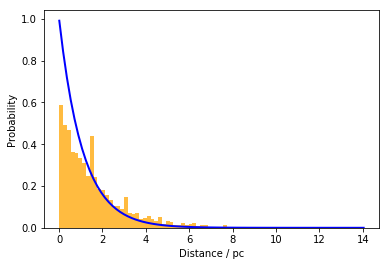

In [82]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def p_decay(dist):
    """distance should be in pc"""
    halflife = 0.8399 # in s
    mass = 8.02248736*amu
    E = 1*EeV
    
    lifetime = halflife #* np.log(2)
    gamma = E / (mass * c_squared)
    mean_dist = lifetime*gamma*c_light / pc
    
    return math.exp(-dist/mean_dist)

print(0.8399 / np.log(2) *1*EeV / (8.02248736*amu * c_squared)*c_light / pc)

n, bins, patches = plt.hist(dists, 80, normed=1, facecolor='orange', alpha=0.75)
y = [p_decay(b) for b in bins]
_ = plt.plot(bins, y, 'b', linewidth=2)
_ = plt.xlabel('Distance / pc')
_ = plt.ylabel('Probability')

Some modules have an additional functionality besides `process`. For example, there is a possibility to plot the dependence on energy of the abovementioned decay using the same module but without candidate:

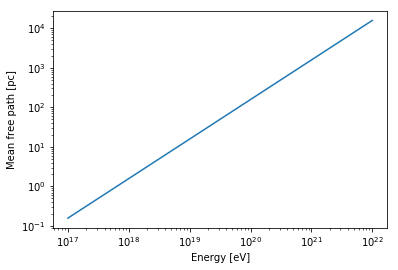

In [44]:
pid = nucleusId(8, 3)
mass = nuclearMass(pid)
energies = 10**np.linspace(17, 22, 100)*eV
meanpath = np.zeros(100)
module = NuclearDecay()

for i, E in enumerate(energies):
    gamma = E / (mass * c_squared)
    meanpath[i] = module.meanFreePath(pid, gamma)

_ = plt.plot(energies / eV, meanpath / pc)
_ = plt.xlabel('Energy [eV]')
_ = plt.ylabel('Mean free path [pc]')
_ = plt.loglog()

### ModuleList and sources

For the sake of transparency and simplicity the first two simulation examples use the explicit for-loop to iterate modules, but it is better to delegate this main loop to CRPropa itself due to performance reasons and some additional features. The **module iterator**, named ``ModuleList``, operates basically like above for-loops: desired modules are added to ``ModuleList`` and then a simulation is being run in its run method.

Here is an example with several other available modules: ``PhotoPionProduction``, ``ElectronPairProduction`` and ``MaximumTrajectoryLength``.

In [15]:
pid = nucleusId(8, 3)
E = 1*EeV
c = Candidate(pid, E)
c.current.setPosition(Vector3d(0, 0, 0)*Mpc)
c.current.setDirection(Vector3d(1, 0, 0))

sim = ModuleList()
sim.add(SimplePropagation())
sim.add(NuclearDecay())
sim.add(PhotoPionProduction(CMB))
sim.add(ElectronPairProduction(CMB))
sim.add(MaximumTrajectoryLength(10*Mpc))

sim.run(c)

print("Charge {} e, Energy: {} EeV"
      .format(c.current.getCharge() / eplus, c.current.getEnergy() / EeV))

Charge 2.0 e, Energy: 0.49889470221750665 EeV


One should take care that there is at least one stopping condition, like ``MaximumTrajectoryLength`` module here, otherwise the loop would never end.

Manually preparing and inserting individual candidates into the simulation box, like in above examples, is sometimes useful for specific purposes, but generally an automatic insertion of candidates according to specified properties is a more common scenario. This mechanism is provided by **sources of particles** which are described by ``Source`` class and its derivated classes. ``Source`` accepts different properties, refered as ``SourceFeature``, like a source position, composition and energy spectrum of injected particles, redshift, directions of the injection and so on.

In [16]:
source = Source()
source.add(SourceParticleType(nucleusId(1, 1))) # protons only
source.add(SourcePowerLawSpectrum(1*EeV, 1000*EeV, -1))
source.add(SourceIsotropicEmission())
source.add(SourcePosition(Vector3d(5, 5, 5)*Mpc))

The Source object is supplied to the ModuleList as an argument of the run method together with the total number of candidates which would be injected. The syntax is the following:

In [18]:
sim.run(source, 10000, True)

The third argument means that the ModuleList should propagate children candidates created in physical interactions - recursively. Processing of children candidates starts after finishing propagation of the original particle.

CRPropa optionally utilises [OpenMP](http://openmp.org), a shared-memory parallel processing framework, which enables it to process multiple candidates in parallel if the underlying system and hardware unit supports multithreading. Usually, OpenMP speeds up the simulation almost linearly (up to 8 cores), but in cost of an indeterministic ordering of results in output files. Hence if the ordering is important, like with trajectory output, or in a case of debugging the code to simplify the execution, the parallel processing can be disabled by specifying the environment variable ``OMP_NUM_THREADS=1`` before running the script.

### Observer and output methods

With the source object CRPropa offers systematical injection of candidates, but after reaching a stopping condition they are just discared. Thus, there should also exist antoher side of the pipline where candidates are systematically detected. An object which fulfill the role of detector is called **observer** and it is embodied in the Observer class. The observer is a module serving as an artificial geometrical boundary where different actions can be triggered when candidate cross the boundary, the most common action is to save the state of the detected candidate into a file.